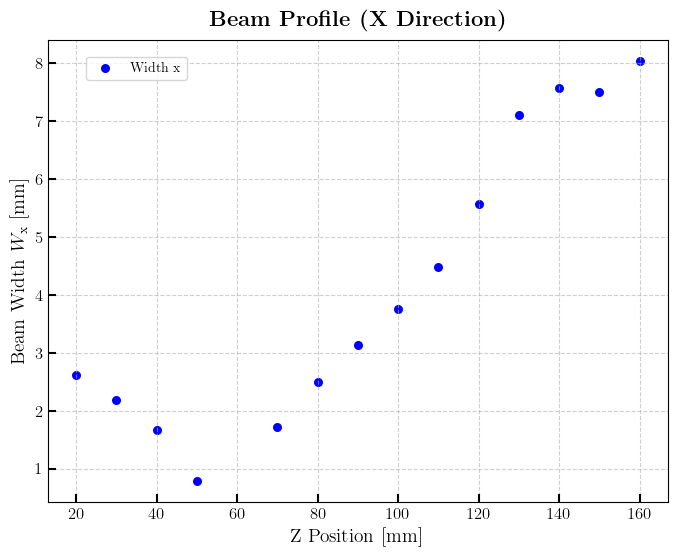

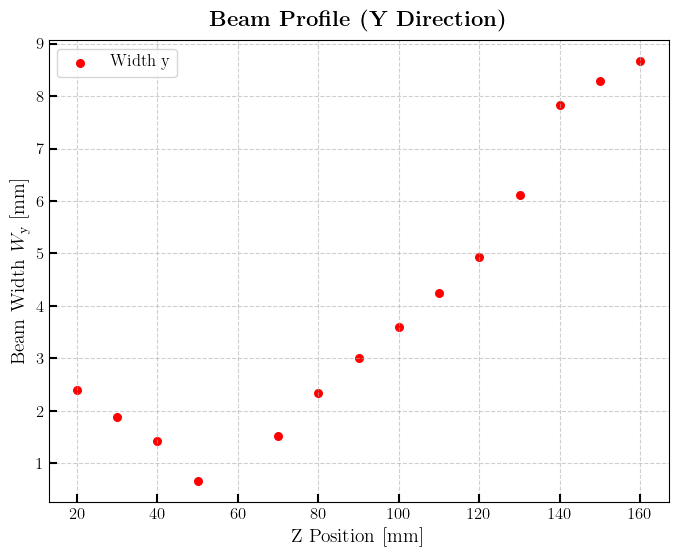

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data path
data_path = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250313/"
file_list = sorted(glob.glob(os.path.join(data_path, "0_*mm Beam Results.csv")))

# Initializations
z_values = []
width_x = []
width_y = []

# Extract data
for file in file_list:
    filename = os.path.basename(file)
    z = int(filename.split('_')[1].split('mm')[0]) 
    z_values.append(z)

    # Read file contents
    with open(file, 'r') as f:
        lines = f.readlines()

    # Extract Width x and Width y from the text file
    for i, line in enumerate(lines):
        if "Width x" in line:
            width_x.append(float(line.split()[2])) 
        if "Width y" in line:
            width_y.append(float(line.split()[2])) 

# Convert to numpy arrays 
z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

# Sort the data by z-values (increasing order)
sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Plot Width x vs. z
plt.figure(figsize=(8, 6))
plt.scatter(z_values, width_x, color='b', marker='o', s=30, label=r'Width x')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.05, 0.98), frameon=True)
#plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot Width y vs. z
plt.figure(figsize=(8, 6))
plt.scatter(z_values, width_y, color='r', marker='o', s=30, label=r'Width y')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### FITTING WITH ABCD MATRIX

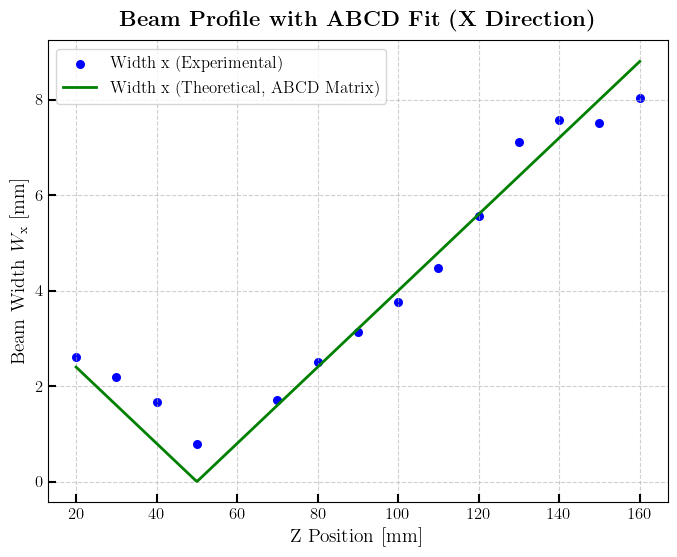

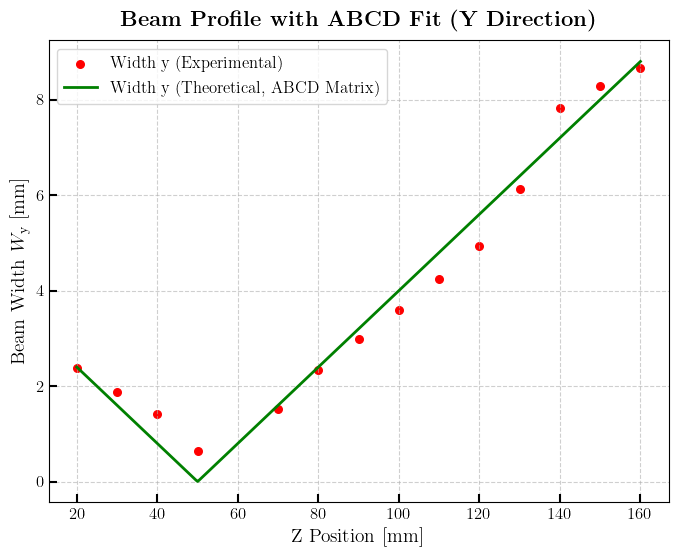

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data path
data_path = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250313/"
file_list = sorted(glob.glob(os.path.join(data_path, "0_*mm Beam Results.csv")))

z_values = []
width_x = []
width_y = []

for file in file_list:
    filename = os.path.basename(file)
    z = int(filename.split('_')[1].split('mm')[0])  
    z_values.append(z)

    with open(file, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if "Width x" in line:
            width_x.append(float(line.split()[2]))  
        if "Width y" in line:
            width_y.append(float(line.split()[2]))  

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length = 50  # in mm
wavelength = 1.060e-3  # in mm 

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

'''
Initial beam parameter before the lens:
Assuming the beam to be collimated but with a finite waist before the lens
Estimate the beam waist before the lens (W0_initial) and its position
The lens focuses the beam at z = 50 mm, use the lens formula for Gaussian beams
'''

# Assume initial beam waist before the lens
W0_initial = 4  # Initial beam waist in mm (before the lens)
z_R_initial = np.pi * W0_initial**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0

# Apply the lens transformation at z = 0
A_lens = 1
B_lens = 0
C_lens = -1 / focal_length
D_lens = 1

q1 = (A_lens * q0 + B_lens) / (C_lens * q0 + D_lens)  # Beam parameter just after the lens

# Theoretical z-values for the curve
z_theoretical = np.linspace(min(z_values), max(z_values), 500)
W_theoretical = np.zeros_like(z_theoretical)

# Propagate the beam in free space after the lens
for i, z in enumerate(z_theoretical):
    # ABCD matrix for free space propagation
    A_free = 1
    B_free = z
    C_free = 0
    D_free = 1

    # Transform the beam parameter
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new

    # Beam width from the imaginary part of 1/q_new
    # Ensure the imaginary part is negative (as expected for a Gaussian beam)
    if inv_q_new.imag < 0:
        W_theoretical[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical[i] = np.nan 

# Plot Width x vs. z 
plt.figure(figsize=(8, 6))
plt.scatter(z_values, width_x, color='b', label='Width x (Experimental)', marker='o', s=30)
plt.plot(z_theoretical, W_theoretical, color='g', linestyle='-', linewidth=2, label='Width x (Theoretical, ABCD Matrix)')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot Width y vs. z 
plt.figure(figsize=(8, 6))
plt.scatter(z_values, width_y, color='r', label='Width y (Experimental)', marker='o', s=30)
plt.plot(z_theoretical, W_theoretical, color='g', linestyle='-', linewidth=2, label='Width y (Theoretical, ABCD Matrix)')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### FITTING WITH SEIGMAN FORMALISM

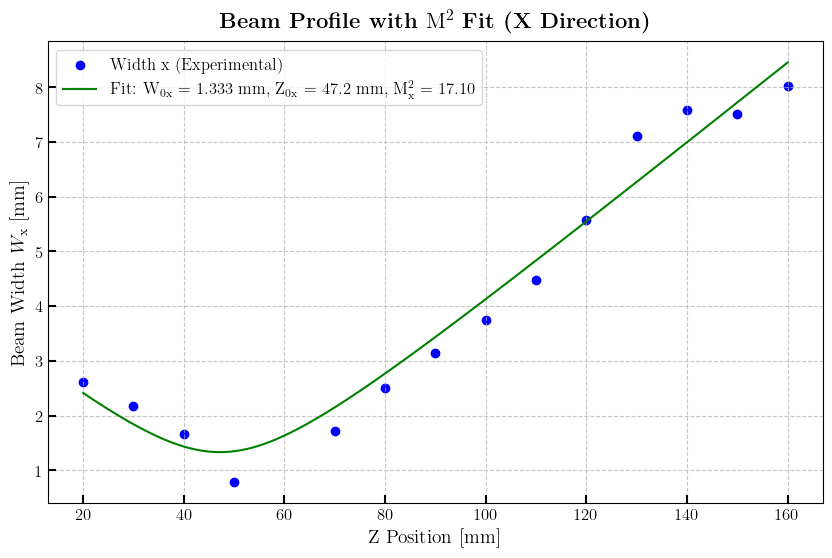

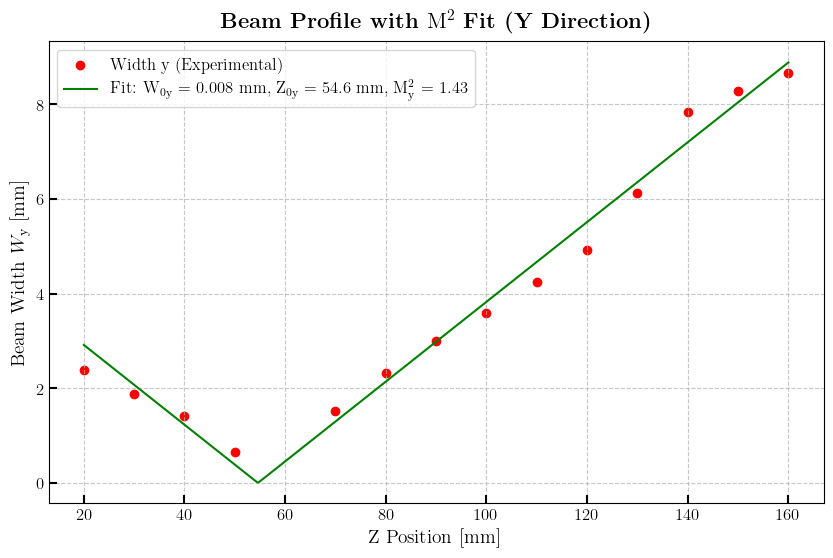

Fitted Parameters for x-direction:
W_0x = 1.333 ± 0.737 mm
z_0x = 47.2 ± 6.9 mm
M_x^2 = 17.10 ± 4.73

Fitted Parameters for y-direction:
W_0y = 0.008 ± 94.786 mm
z_0y = 54.6 ± 3.7 mm
M_y^2 = 1.43 ± 8273.58

Experimental Data:
z = 20 mm, Width_x = 2.611 mm, Width_y = 2.386 mm
z = 30 mm, Width_x = 2.183 mm, Width_y = 1.872 mm
z = 40 mm, Width_x = 1.660 mm, Width_y = 1.415 mm
z = 50 mm, Width_x = 0.779 mm, Width_y = 0.651 mm
z = 70 mm, Width_x = 1.712 mm, Width_y = 1.523 mm
z = 80 mm, Width_x = 2.497 mm, Width_y = 2.331 mm
z = 90 mm, Width_x = 3.142 mm, Width_y = 2.996 mm
z = 100 mm, Width_x = 3.753 mm, Width_y = 3.587 mm
z = 110 mm, Width_x = 4.481 mm, Width_y = 4.254 mm
z = 120 mm, Width_x = 5.572 mm, Width_y = 4.927 mm
z = 130 mm, Width_x = 7.106 mm, Width_y = 6.121 mm
z = 140 mm, Width_x = 7.576 mm, Width_y = 7.830 mm
z = 150 mm, Width_x = 7.503 mm, Width_y = 8.287 mm
z = 160 mm, Width_x = 8.030 mm, Width_y = 8.660 mm


In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data path
data_path = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250313/"
file_list = sorted(glob.glob(os.path.join(data_path, "0_*mm Beam Results.csv")))

z_values = []
width_x = []
width_y = []

# Read experimental data
for file in file_list:
    filename = os.path.basename(file)
    z = int(filename.split('_')[1].split('mm')[0])  
    z_values.append(z)

    with open(file, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if "Width x" in line:
            width_x.append(float(line.split()[2]))  
        if "Width y" in line:
            width_y.append(float(line.split()[2]))  

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
wavelength = 1.060e-3  # in mm (1060 nm)

# M^2 beam propagation function (based on Siegman)
def beam_width_squared(z, W0, z0, M2):
    """
    W^2(z) = W0^2 + M^4 * (lambda / (pi * W0))^2 * (z - z0)^2
    Parameters:
    - W0: Beam waist size (mm)
    - z0: Waist location (mm)
    - M2: Beam quality factor (M^2)
    """
    theta = M2**2 * (wavelength / (np.pi * W0))  # Far-field divergence term
    return W0**2 + (theta**2) * (z - z0)**2

# Fit parameters [W0, z0, M2]: Initial guess
initial_guess_x = [min(width_x), z_values[np.argmin(width_x)], 1.0] 
initial_guess_y = [min(width_y), z_values[np.argmin(width_y)], 1.0]  

# Fit the model to the squared beam widths for x-direction
try:
    popt_x, pcov_x = curve_fit(beam_width_squared, z_values, width_x**2, p0=initial_guess_x, 
                               bounds=([0, min(z_values), 1], [np.inf, max(z_values), np.inf]), 
                               maxfev=10000) # Max function evaluations (increase if needed)   
    W0x_fit, z0x_fit, M2x_fit = popt_x
    W0x_err, z0x_err, M2x_err = np.sqrt(np.diag(pcov_x))  # Standard errors
except RuntimeError as e:
    print(f"Fit failed for x-direction: {e}")
    W0x_fit, z0x_fit, M2x_fit = initial_guess_x  # Fallback to initial guess
    W0x_err, z0x_err, M2x_err = [np.nan, np.nan, np.nan]

# Fit the model to the squared beam widths for y-direction
try:
    popt_y, pcov_y = curve_fit(beam_width_squared, z_values, width_y**2, p0=initial_guess_y, 
                               bounds=([0, min(z_values), 1], [np.inf, max(z_values), np.inf]), 
                               maxfev=10000)  
    W0y_fit, z0y_fit, M2y_fit = popt_y
    W0y_err, z0y_err, M2y_err = np.sqrt(np.diag(pcov_y))  
except RuntimeError as e:
    print(f"Fit failed for y-direction: {e}")
    W0y_fit, z0y_fit, M2y_fit = initial_guess_y 
    W0y_err, z0y_err, M2y_err = [np.nan, np.nan, np.nan]

# Generate theoretical curves for plotting
z_theoretical = np.linspace(min(z_values), max(z_values), 500)
Wx_theoretical = np.sqrt(beam_width_squared(z_theoretical, W0x_fit, z0x_fit, M2x_fit))
Wy_theoretical = np.sqrt(beam_width_squared(z_theoretical, W0y_fit, z0y_fit, M2y_fit))

# Plot Width x vs. z
plt.figure(figsize=(10, 6))
plt.scatter(z_values, width_x, color='b', label='Width x (Experimental)')
plt.plot(z_theoretical, Wx_theoretical, color='g', linestyle='-',
         label=r'Fit: $\rm{W_{0x}}$' + f' = {W0x_fit:.3f} mm, 'r'$\rm{Z_{{0x}}}$' + f' = {z0x_fit:.1f} mm, ' r'$\rm{M_x^2}$' + f' = {M2x_fit:.2f}')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with $\rm{M}^2$ Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot Width y vs. z
plt.figure(figsize=(10, 6))
plt.scatter(z_values, width_y, color='r', label='Width y (Experimental)')
plt.plot(z_theoretical, Wy_theoretical, color='g', linestyle='-',
         label=r'Fit: $\rm{W_{0y}}$' + f' = {W0y_fit:.3f} mm, 'r'$\rm{Z_{{0y}}}$' + f' = {z0y_fit:.1f} mm, ' r'$\rm{M_y^2}$' + f' = {M2y_fit:.2f}')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with $\rm{M}^2$ Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Print fitted parameters with errors
print("Fitted Parameters for x-direction:")
print(f"W_0x = {W0x_fit:.3f} ± {W0x_err:.3f} mm")
print(f"z_0x = {z0x_fit:.1f} ± {z0x_err:.1f} mm")
print(f"M_x^2 = {M2x_fit:.2f} ± {M2x_err:.2f}")

print("\nFitted Parameters for y-direction:")
print(f"W_0y = {W0y_fit:.3f} ± {W0y_err:.3f} mm")
print(f"z_0y = {z0y_fit:.1f} ± {z0y_err:.1f} mm")
print(f"M_y^2 = {M2y_fit:.2f} ± {M2y_err:.2f}")

# Print data
print("\nExperimental Data:")
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Width_x = {wx:.3f} mm, Width_y = {wy:.3f} mm")